<a href="https://colab.research.google.com/github/Hassan-293/My-Project/blob/main/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls '/content/drive/MyDrive/Histo Data'

lizard_images1	lizard_images2	lizard_labels  overlay


In [9]:
!mkdir '/content/drive/MyDrive/Histo Data/processed'

In [18]:
from tensorflow import keras
import cv2


In [47]:
import os
import cv2
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/Histo Data/lizard_images1/Lizard_Images1'
processed_path = '/content/drive/MyDrive/Histo Data/lizard_images1/Lizard_Images1_Processed'

for filename in os.listdir(path):
    if filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(path, filename))

        # Resize the image
        image = cv2.resize(image, (224, 224))

        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Normalize the image
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        # Save the processed image
        cv2.imwrite(f'/content/drive/MyDrive/Histo Data/lizard_images1/Lizard_Images1_Processed/consep_10.png', image)


In [29]:

def display_image(image_path):
    # Load the image
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.show()

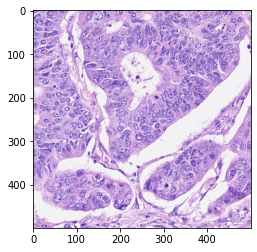

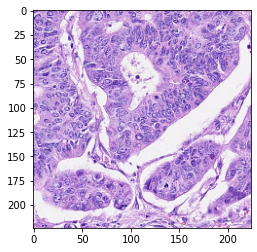

In [42]:
X='/content/drive/MyDrive/Histo Data/lizard_images1/Lizard_Images1/consep_1.png'


display_image(X)

display_image('/content/drive/MyDrive/Histo Data/processed/consep_1.png')



In [50]:
!git config --global user.email "shiekhhassan1234draq@gmail.com"
!git config --global user.name "Hassan-293"


In [51]:
!git init

Initialized empty Git repository in /content/.git/


In [53]:
!git add Cancer_Detection.ipynb

fatal: pathspec 'Cancer_Detection.ipynb' did not match any files


In [54]:
!git remote add origin https://github.com/Hassan-293/https://github.com/Hassan-293/My-Project.git


In [55]:
!git push -u origin master

error: src refspec master does not match any
error: failed to push some refs to 'https://github.com/Hassan-293/https://github.com/Hassan-293/My-Project.git'
